<a href="https://colab.research.google.com/github/Benylaode/Rekomendasi_Clothing/blob/main/Sistem_Rekomendasi_Pakaian_Berbasis_Konten_(Diperbarui).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


# --- 1. Data Understanding ---
# Memuat dataset
# Asumsikan file CSV berada di direktori yang sama atau path yang sesuai

In [31]:

try:
    df = pd.read_csv('Womens Clothing E-Commerce Reviews.csv', index_col=0)
    print("Dataset berhasil dimuat.")
except FileNotFoundError:
    print("Error: File 'Women_Clothing_E-Commerce_Reviews.csv' tidak ditemukan.")
    print("Pastikan file dataset berada di direktori yang sama dengan notebook ini.")
    exit() # Keluar jika file tidak ditemukan

Dataset berhasil dimuat.


In [32]:
print("\n--- Tampilan Awal Dataset ---")
print(df.head())

print("\n--- Informasi Dataset ---")
df.info()

print(f"\nDimensi Dataset: {df.shape[0]} baris, {df.shape[1]} kolom")

print("\n--- Statistik Deskriptif ---")
print(df.describe())

print("\n--- Cek Missing Values Awal ---")
print(df.isnull().sum())

print("\n--- Jumlah Nilai Unik per Kolom ---")
print(df.nunique())


--- Tampilan Awal Dataset ---
   Clothing ID  Age                    Title  \
0          767   33                      NaN   
1         1080   34                      NaN   
2         1077   60  Some major design flaws   
3         1049   50         My favorite buy!   
4          847   47         Flattering shirt   

                                         Review Text  Rating  Recommended IND  \
0  Absolutely wonderful - silky and sexy and comf...       4                1   
1  Love this dress!  it's sooo pretty.  i happene...       5                1   
2  I had such high hopes for this dress and reall...       3                0   
3  I love, love, love this jumpsuit. it's fun, fl...       5                1   
4  This shirt is very flattering to all due to th...       5                1   

   Positive Feedback Count   Division Name Department Name Class Name  
0                        0       Initmates        Intimate  Intimates  
1                        4         General       

Dataset ini berisi 23.486 ulasan pelanggan produk fashion, mencakup usia, ulasan teks, rating, dan apakah produk direkomendasikan. Terdapat kombinasi fitur numerik dan kategorikal, dengan beberapa nilai hilang di kolom `Title`, `Review Text`, dan kategori produk. Sebagian besar rating tinggi dan ulasan bersifat positif, menunjukkan kecenderungan pengguna untuk merekomendasikan produk.


--- Visualisasi Data untuk Pemahaman Konsep (EDA) ---

<ipython-input-33-966dc5ce8b1a>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Rating', data=df, palette='viridis')


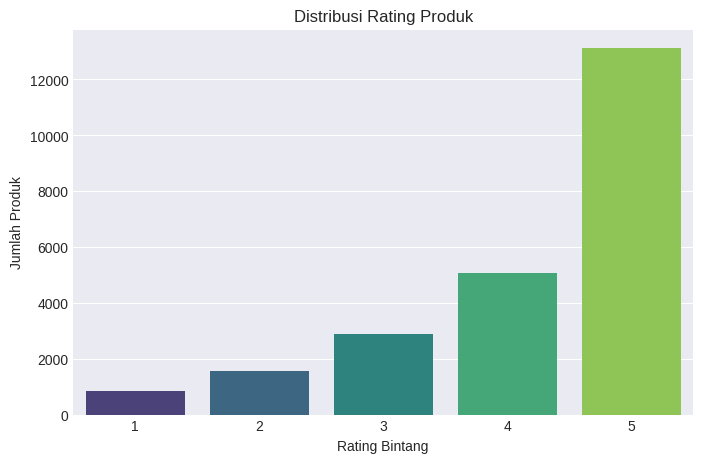

<ipython-input-33-966dc5ce8b1a>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Division Name', data=df, order=df['Division Name'].value_counts().index, palette='plasma')


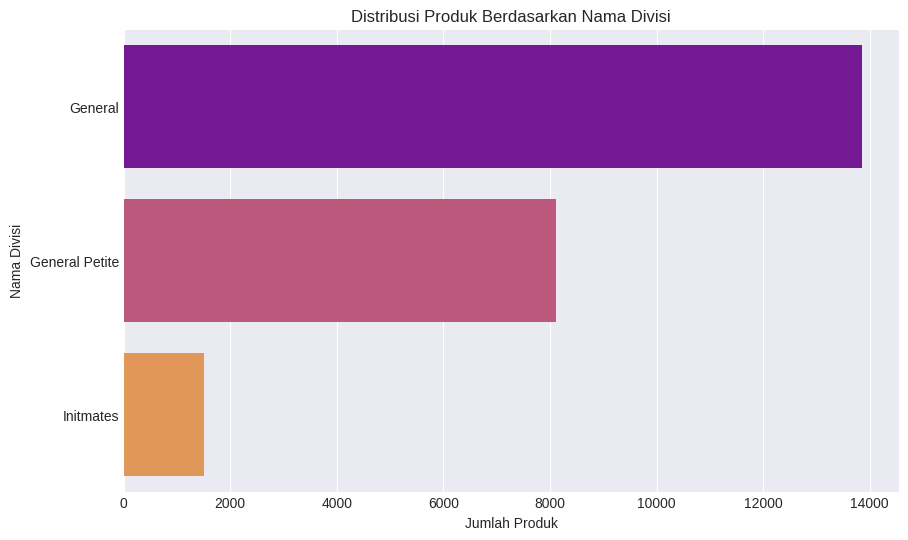

<ipython-input-33-966dc5ce8b1a>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Department Name', data=df, order=df['Department Name'].value_counts().index, palette='magma')


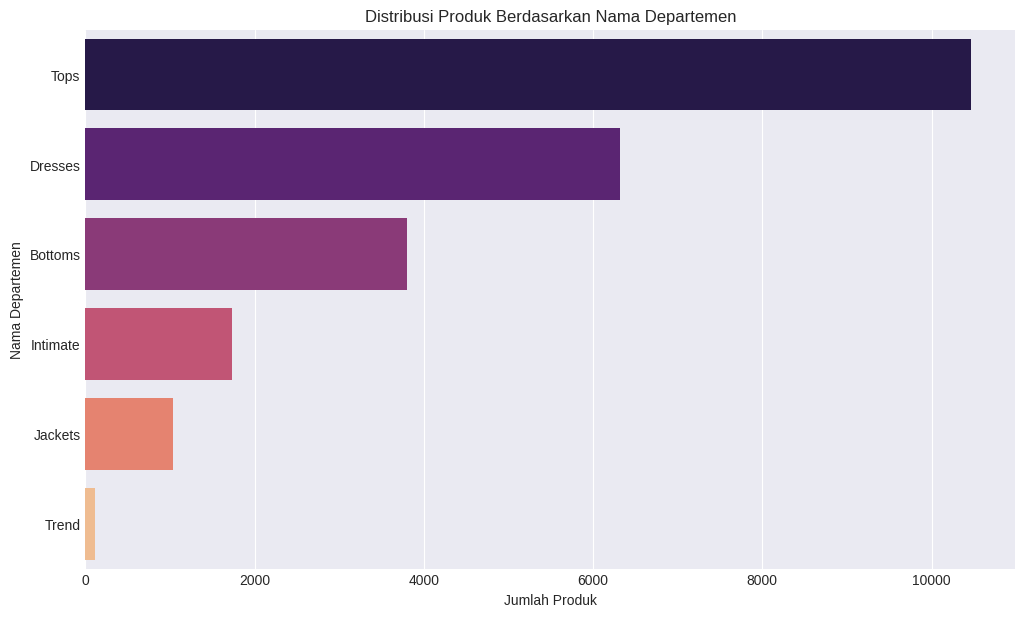

<ipython-input-33-966dc5ce8b1a>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Class Name', data=df[df['Class Name'].isin(top_classes)], order=top_classes, palette='cividis')


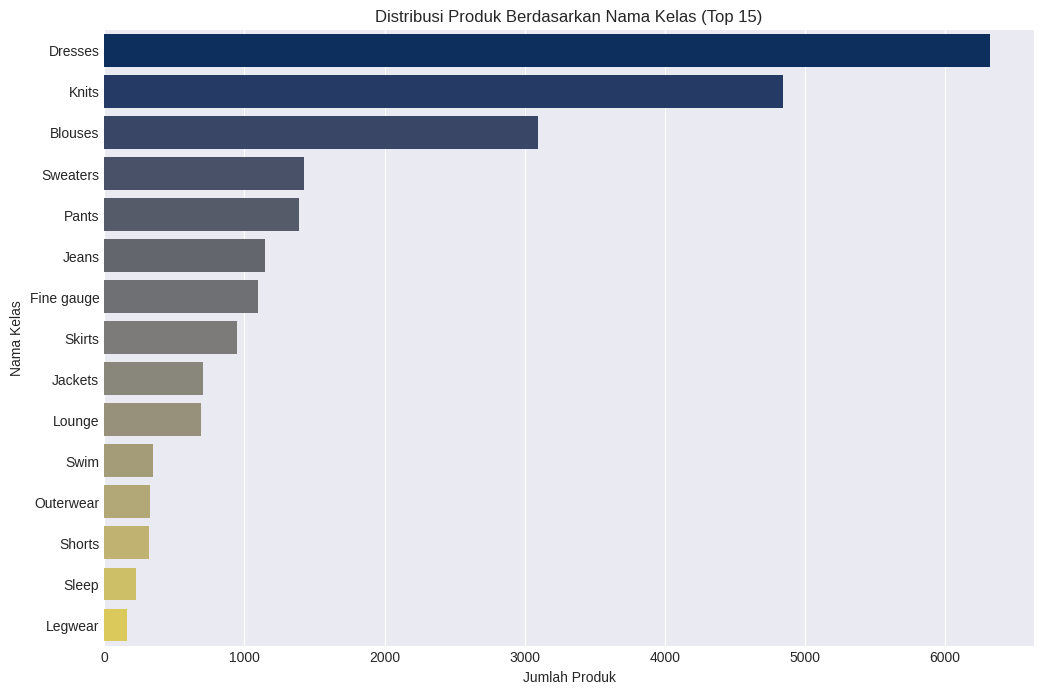

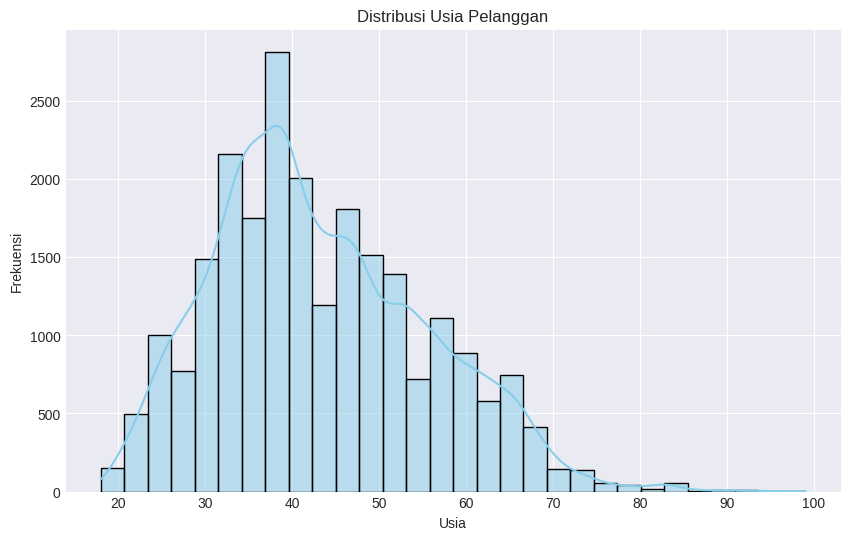

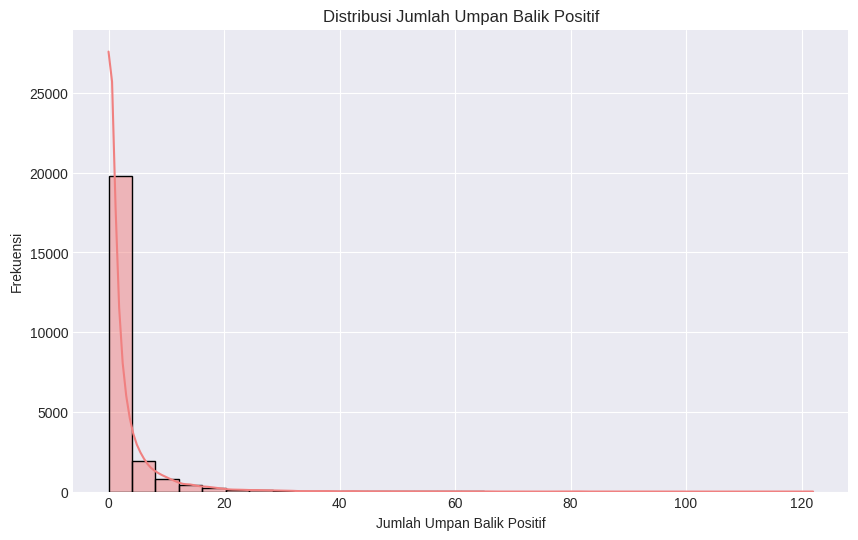

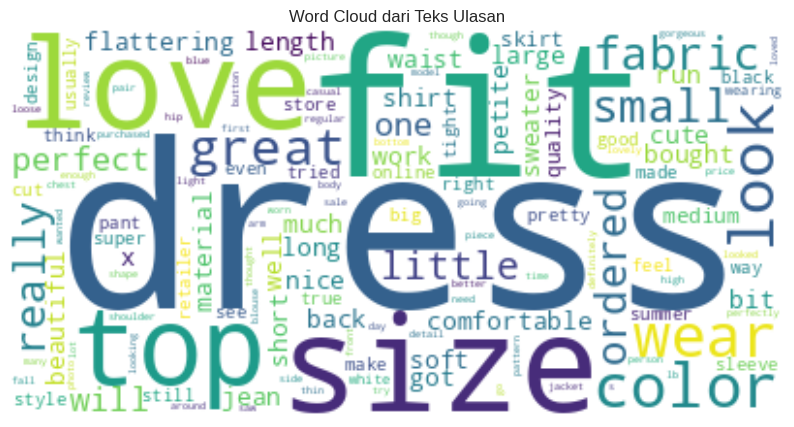

In [33]:

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)

plt.figure(figsize=(8, 5))
sns.countplot(x='Rating', data=df, palette='viridis')
plt.title('Distribusi Rating Produk')
plt.xlabel('Rating Bintang')
plt.ylabel('Jumlah Produk')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(y='Division Name', data=df, order=df['Division Name'].value_counts().index, palette='plasma')
plt.title('Distribusi Produk Berdasarkan Nama Divisi')
plt.xlabel('Jumlah Produk')
plt.ylabel('Nama Divisi')
plt.show()

plt.figure(figsize=(12, 7))
sns.countplot(y='Department Name', data=df, order=df['Department Name'].value_counts().index, palette='magma')
plt.title('Distribusi Produk Berdasarkan Nama Departemen')
plt.xlabel('Jumlah Produk')
plt.ylabel('Nama Departemen')
plt.show()

plt.figure(figsize=(12, 8))
top_classes = df['Class Name'].value_counts().head(15).index
sns.countplot(y='Class Name', data=df[df['Class Name'].isin(top_classes)], order=top_classes, palette='cividis')
plt.title('Distribusi Produk Berdasarkan Nama Kelas (Top 15)')
plt.xlabel('Jumlah Produk')
plt.ylabel('Nama Kelas')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df['Age'].dropna(), bins=30, kde=True, color='skyblue')
plt.title('Distribusi Usia Pelanggan')
plt.xlabel('Usia')
plt.ylabel('Frekuensi')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df['Positive Feedback Count'].dropna(), bins=30, kde=True, color='lightcoral')
plt.title('Distribusi Jumlah Umpan Balik Positif')
plt.xlabel('Jumlah Umpan Balik Positif')
plt.ylabel('Frekuensi')
plt.show()

temp_review_text = df['Review Text'].fillna('').astype(str)
long_string = ','.join(list(temp_review_text.values))
wordcloud = WordCloud(background_color="white", max_words=500, contour_width=3, contour_color='steelblue', collocations=False)
wordcloud.generate(long_string)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Word Cloud dari Teks Ulasan')
plt.show()


bisa dilihat dari hasl visualisasi di atas menunjukan bawah data memiliki beberapa favorit data seperti jumlah dress yang banyak peminatnya dan juga rentang usia pembelajang yang mayoritas 30-60 ke atas,  dan juga secara konsep jenis barang yang paling banyak direview adalah dress yang berasal dari departemen dereses, ini menunjukan bahwa sebagian besar data itu melakukan review terhadap dress. dan kata yang paling seliring mucnul jjuga adalah dress

# --- 2. Data Preparation ---

# --- 2.1. Menangani Data Duplikat ---
dengan melakukan drop duplikat

In [34]:

print("\n--- Menangani Data Duplikat ---")
initial_rows = df.shape[0]
df.drop_duplicates(inplace=True)
rows_after_duplicates = df.shape[0]
print(f"Jumlah baris sebelum menghapus duplikat: {initial_rows}")
print(f"Jumlah baris setelah menghapus duplikat: {rows_after_duplicates}")
print(f"Jumlah duplikat yang dihapus: {initial_rows - rows_after_duplicates}")


--- Menangani Data Duplikat ---
Jumlah baris sebelum menghapus duplikat: 23486
Jumlah baris setelah menghapus duplikat: 23465
Jumlah duplikat yang dihapus: 21


# --- 2.2. Menangani Missing Values (NaN/Null) ---
data yang bersifat numerik saya berikan isi dengan rata-rata dan review teks dengan teks kosong karena bersifat bias jika diisi secara tidak baik

In [35]:
for col in ['Age', 'Positive Feedback Count']:
    if df[col].isnull().any():
        mean_val = df[col].mean()
        df[col].fillna(mean_val, inplace=True)
        print(f"Kolom '{col}' NaN diisi dengan rata-rata: {mean_val:.2f}")

if df['Review Text'].isnull().any():
    df['Review Text'] = df['Review Text'].fillna('')
    print("Kolom 'Review Text' NaN diisi dengan string kosong.")

for col in ['Division Name', 'Department Name', 'Class Name']:
    if df[col].isnull().any():
        df[col] = df[col].fillna('unknown')
        print(f"Kolom '{col}' NaN diisi dengan 'unknown'.")

print("\n--- Cek Missing Values Setelah Penanganan ---")
print(df.isnull().sum())

Kolom 'Review Text' NaN diisi dengan string kosong.
Kolom 'Division Name' NaN diisi dengan 'unknown'.
Kolom 'Department Name' NaN diisi dengan 'unknown'.
Kolom 'Class Name' NaN diisi dengan 'unknown'.

--- Cek Missing Values Setelah Penanganan ---
Clothing ID                   0
Age                           0
Title                      3789
Review Text                   0
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                 0
Department Name               0
Class Name                    0
dtype: int64


# --- 2.3. Menangani Outlier dengan Metode IQR (Interquartile Range) ---

In [36]:

numerical_cols = ['Age', 'Positive Feedback Count', 'Rating']
for col in numerical_cols:
    if pd.api.types.is_numeric_dtype(df[col]):
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers_count = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
        print(f"Kolom '{col}': {outliers_count} outlier teridentifikasi.")


        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
        print(f"Outlier pada kolom '{col}' telah di-capping.")
    else:
        print(f"Kolom '{col}' bukan tipe numerik, outlier tidak ditangani.")

print("\n--- Statistik Deskriptif Setelah Penanganan Outlier ---")
print(df[numerical_cols].describe())

Kolom 'Age': 109 outlier teridentifikasi.
Outlier pada kolom 'Age' telah di-capping.
Kolom 'Positive Feedback Count': 2147 outlier teridentifikasi.
Outlier pada kolom 'Positive Feedback Count' telah di-capping.
Kolom 'Rating': 2407 outlier teridentifikasi.
Outlier pada kolom 'Rating' telah di-capping.

--- Statistik Deskriptif Setelah Penanganan Outlier ---
                Age  Positive Feedback Count        Rating
count  23465.000000             23465.000000  23465.000000
mean      43.174515                 1.775048      4.282527
std       12.196965                 2.454412      0.912203
min       18.000000                 0.000000      2.500000
25%       34.000000                 0.000000      4.000000
50%       41.000000                 1.000000      5.000000
75%       52.000000                 3.000000      5.000000
max       79.000000                 7.500000      5.000000


# --- 2.4. Menggabungkan Fitur Teks dan Pembersihan ---
karena konsep pendekatan TF-IDF yang kita gunakan maka kita harus mengabungkan fitur teks dan melakukan pembersihan terhdap fiturnya

In [37]:


df['content'] = df['Review Text'] + ' ' + \
                df['Division Name'] + ' ' + \
                df['Department Name'] + ' ' + \
                df['Class Name']

def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

df['content'] = df['content'].apply(clean_text)

print("\n--- Contoh Kolom 'content' Setelah Digabungkan dan Dibersihkan ---")
print(df[['Review Text', 'Division Name', 'Department Name', 'Class Name', 'content']].head())


--- Contoh Kolom 'content' Setelah Digabungkan dan Dibersihkan ---
                                         Review Text   Division Name  \
0  Absolutely wonderful - silky and sexy and comf...       Initmates   
1  Love this dress!  it's sooo pretty.  i happene...         General   
2  I had such high hopes for this dress and reall...         General   
3  I love, love, love this jumpsuit. it's fun, fl...  General Petite   
4  This shirt is very flattering to all due to th...         General   

  Department Name Class Name  \
0        Intimate  Intimates   
1         Dresses    Dresses   
2         Dresses    Dresses   
3         Bottoms      Pants   
4            Tops    Blouses   

                                             content  
0  absolutely wonderful  silky and sexy and comfo...  
1  love this dress  its sooo pretty  i happened t...  
2  i had such high hopes for this dress and reall...  
3  i love love love this jumpsuit its fun flirty ...  
4  this shirt is very flatterin

# --- 2.5. Vektorisasi TF-IDF ---
memnafaatkan vektor tf-id yang nanti akan digunakan untuk proses pencarian menggunakan cos_similarity

In [38]:

df_unique = df.drop_duplicates(subset='Clothing ID').reset_index(drop=True)

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df_unique['content'])

print(f"\nUkuran matriks TF-IDF: {tfidf_matrix.shape}")
print(f"Jumlah fitur (kata unik) yang digunakan: {len(tfidf_vectorizer.get_feature_names_out())}")

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

print(f"\nUkuran matriks Cosine Similarity: {cosine_sim.shape}")
print("Contoh matriks Cosine Similarity (5x5 teratas):\n", cosine_sim[:5, :5])

cosine_sim_df = pd.DataFrame(cosine_sim, index=df_unique['Clothing ID'], columns=df_unique['Clothing ID'])

print("\n--- Contoh DataFrame Cosine Similarity ---")
print(cosine_sim_df.head())


Ukuran matriks TF-IDF: (1206, 3952)
Jumlah fitur (kata unik) yang digunakan: 3952

Ukuran matriks Cosine Similarity: (1206, 1206)
Contoh matriks Cosine Similarity (5x5 teratas):
 [[1.         0.         0.01987606 0.         0.        ]
 [0.         1.         0.12464025 0.13041802 0.05355199]
 [0.01987606 0.12464025 1.         0.0279826  0.00434257]
 [0.         0.13041802 0.0279826  1.         0.08486616]
 [0.         0.05355199 0.00434257 0.08486616 1.        ]]

--- Contoh DataFrame Cosine Similarity ---
Clothing ID      767       1080      1077      1049      847       858   \
Clothing ID                                                               
767          1.000000  0.000000  0.019876  0.000000  0.000000  0.000000   
1080         0.000000  1.000000  0.124640  0.130418  0.053552  0.057347   
1077         0.019876  0.124640  1.000000  0.027983  0.004343  0.024408   
1049         0.000000  0.130418  0.027983  1.000000  0.084866  0.037100   
847          0.000000  0.053552  0.

In [39]:
cosine_sim_df.head()

Clothing ID,767,1080,1077,1049,847,858,1095,1065,853,1120,...,487,387,640,345,630,430,262,181,721,522
Clothing ID,,,,,,,,,,,,,,,,,,,,,
767,1.000000,0.000000,0.019876,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.012546,0.243525,0.011752,0.029837,0.000000,0.063642,0.052394,0.041602,0.017463,0.032513
1080,0.000000,1.000000,0.124640,0.130418,0.053552,0.057347,0.319447,0.019977,0.053740,0.006240,...,0.017375,0.051337,0.069991,0.000000,0.090100,0.022428,0.121814,0.000000,0.139227,0.000000
1077,0.019876,0.124640,1.000000,0.027983,0.004343,0.024408,0.175212,0.065119,0.002786,0.054028,...,0.004783,0.013563,0.037545,0.014168,0.015596,0.067589,0.046809,0.025511,0.035040,0.000000
1049,0.000000,0.130418,0.027983,1.000000,0.084866,0.037100,0.052755,0.045993,0.060191,0.032574,...,0.025471,0.083006,0.034043,0.000000,0.113634,0.035697,0.119644,0.000000,0.124936,0.030923
847,0.000000,0.053552,0.004343,0.084866,1.000000,0.012991,0.062060,0.005869,0.088472,0.039776,...,0.007330,0.038674,0.008956,0.191056,0.031653,0.015410,0.050616,0.000000,0.151957,0.000000


# --- 3. Modeling untuk Rekomendasi  menggunakan Content-Based Filtering dengan pendekatan cosine similarity.  ---

In [40]:
def get_recommendations(clothing_id, cosine_sim_df, df, num_recommendations=10):

    if clothing_id not in cosine_sim_df.columns:
        print(f"Pakaian dengan ID {clothing_id} tidak ditemukan dalam dataset.")
        return pd.DataFrame()

    sim_scores_df = cosine_sim_df[[clothing_id]].copy()

    sim_scores_df = sim_scores_df.rename(columns={clothing_id: 'similarity'})

    sim_scores_df = sim_scores_df.drop(index=clothing_id, errors='ignore')

    sim_scores_df = sim_scores_df.sort_values(by='similarity', ascending=False)

    top_recommendations_ids = sim_scores_df.head(num_recommendations).index.tolist()

    recommended_items = df[df['Clothing ID'].isin(top_recommendations_ids)].drop_duplicates(subset=['Clothing ID'])
    recommended_items = recommended_items.set_index('Clothing ID').loc[top_recommendations_ids].reset_index()

    display_cols = ['Clothing ID', 'Division Name', 'Department Name', 'Class Name', 'Review Text', 'Rating']
    return recommended_items[display_cols]


# --- 4. Evaluasi   Model Rekomendasi dengan teknik Rekomendasi Similaritu  ---

# --- 4.1 Rekomendasi Similarity untuk Content Tertentu  ---

In [41]:
example_clothing_id = df['Clothing ID'].iloc[0]
print(f"\n--- Mencari Rekomendasi untuk Clothing ID: {example_clothing_id} ---")

original_item = df[df['Clothing ID'] == example_clothing_id].drop_duplicates(subset=['Clothing ID'])
print("\nInformasi Pakaian Asli:")

print(original_item[['Clothing ID', 'Division Name', 'Department Name', 'Class Name', 'Review Text', 'Rating']].iloc[0])

recommendations = get_recommendations(example_clothing_id, cosine_sim_df, df, num_recommendations=5)

if not recommendations.empty:
    print(f"\nTop 5 Rekomendasi untuk Clothing ID {example_clothing_id}:")
    print(recommendations)
else:
    print(f"Tidak ada rekomendasi yang ditemukan untuk Clothing ID {example_clothing_id}.")





--- Mencari Rekomendasi untuk Clothing ID: 767 ---

Informasi Pakaian Asli:
Clothing ID                                                      767
Division Name                                              Initmates
Department Name                                             Intimate
Class Name                                                 Intimates
Review Text        Absolutely wonderful - silky and sexy and comf...
Rating                                                           4.0
Name: 0, dtype: object

Top 5 Rekomendasi untuk Clothing ID 767:
   Clothing ID Division Name Department Name Class Name Review Text  Rating
0          361     Initmates        Intimate  Intimates                 4.0
1          284     Initmates        Intimate  Intimates                 2.5
2          411     Initmates        Intimate  Intimates                 5.0
3          102     Initmates        Intimate  Intimates                 5.0
4           92     Initmates        Intimate  Intimates         

# --- 4.2 Rekomendasi Similarity untuk Content Populer  ---

In [42]:
popular_clothing_id = df['Clothing ID'].value_counts().index[0]
print(f"\n--- Mencari Rekomendasi untuk Clothing ID Paling Populer: {popular_clothing_id} ---")

original_item_popular = df[df['Clothing ID'] == popular_clothing_id].drop_duplicates(subset=['Clothing ID'])
print("\nInformasi Pakaian Asli:")
print(original_item_popular[['Clothing ID', 'Division Name', 'Department Name', 'Class Name', 'Review Text', 'Rating']].iloc[0])

recommendations_popular = get_recommendations(popular_clothing_id, cosine_sim_df, df, num_recommendations=5)

if not recommendations_popular.empty:
    print(f"\nTop 5 Rekomendasi untuk Clothing ID {popular_clothing_id}:")
    print(recommendations_popular)
else:
    print(f"Tidak ada rekomendasi yang ditemukan untuk Clothing ID {popular_clothing_id}.")


--- Mencari Rekomendasi untuk Clothing ID Paling Populer: 1078 ---

Informasi Pakaian Asli:
Clothing ID                                                     1078
Division Name                                         General Petite
Department Name                                              Dresses
Class Name                                                   Dresses
Review Text        I really wanted this to work. alas, it had a s...
Rating                                                           3.0
Name: 69, dtype: object

Top 5 Rekomendasi untuk Clothing ID 1078:
   Clothing ID   Division Name Department Name Class Name  \
0         1201         General         Dresses    Dresses   
1         1194         General         Dresses    Dresses   
2         1095  General Petite         Dresses    Dresses   
3           30  General Petite         Dresses    Dresses   
4          982         General         Jackets    Jackets   

                                         Review Text  Ratin

# --- 4.3  Evaluasi metric Demonstrasi Rekomendasi (NDCG)---

In [43]:
def dcg_at_k(relevances, k):
    """
    Menghitung Discounted Cumulative Gain (DCG) pada posisi k.
    Relevansi di sini diasumsikan sebagai rating item.
    """
    relevances = np.asarray(relevances, dtype='float64')[:k]
    if relevances.size == 0:
        return 0.
    return np.sum(relevances / np.log2(np.arange(2, relevances.size + 2)))

def idcg_at_k(relevances, k):
    """
    Menghitung Ideal Discounted Cumulative Gain (IDCG) pada posisi k.
    Relevansi diurutkan dari yang tertinggi untuk mendapatkan nilai ideal.
    """
    rrelevances = np.asarray(relevances, dtype='float64')[:k]
    if len(relevances) == 0:
        return 0.
    return dcg_at_k(np.sort(relevances)[::-1], k)

def ndcg_at_k(relevances, k):
    """
    Menghitung Normalized Discounted Cumulative Gain (nDCG) pada posisi k.
    nDCG = DCG / IDCG.
    """
    dcg_val = dcg_at_k(relevances, k)
    idcg_val = idcg_at_k(relevances, k)
    if idcg_val == 0:
        return 0.
    return dcg_val / idcg_val


num_recs_k = 5 # Jumlah rekomendasi untuk metrik

if not recommendations.empty:
    relevances = recommendations['Rating'].tolist()
    ndcg_score = ndcg_at_k(relevances, num_recs_k)
    print(f"\n--- Penilaian Metrik Kuantitatif untuk Rekomendasi baju tertentu dalam kasus ini ID 767 ---")
    print(f"nDCG@{num_recs_k} untuk rekomendasi ini: {ndcg_score:.4f}")

else:
    print(f"Tidak ada rekomendasi yang ditemukan untuk Clothing ID {example_clothing_id}.")


if not recommendations_popular.empty:

    relevances_popular = recommendations_popular['Rating'].tolist()
    ndcg_score_popular = ndcg_at_k(relevances_popular, num_recs_k)
    print(f"\n--- Penilaian Metrik Kuantitatif untuk Rekomendasi Populer ---")
    print(f"nDCG@{num_recs_k} untuk rekomendasi ini: {ndcg_score_popular:.4f}")
    print("Penjelasan nDCG@K sama seperti di atas.")

else:
    print(f"Tidak ada rekomendasi yang ditemukan untuk Clothing ID {popular_clothing_id}.")




--- Penilaian Metrik Kuantitatif untuk Rekomendasi baju tertentu dalam kasus ini ID 767 ---
nDCG@5 untuk rekomendasi ini: 0.9116

--- Penilaian Metrik Kuantitatif untuk Rekomendasi Populer ---
nDCG@5 untuk rekomendasi ini: 0.9139
Penjelasan nDCG@K sama seperti di atas.


* **Model rekomendasi khusus untuk ID 767** menghasilkan **nDCG\@5 = 0.9116**
* **Model rekomendasi populer (global/populer item)** menghasilkan **nDCG\@5 = 0.9139**

### Interpretasi:

* **nDCG (Normalized Discounted Cumulative Gain)** mengukur kualitas urutan hasil rekomendasi, dengan mempertimbangkan relevansi dan posisi item dalam daftar. Nilai mendekati 1 berarti urutan rekomendasi sangat baik.
* Dalam kasus ini, **rekomendasi populer sedikit mengungguli rekomendasi khusus untuk ID 767**.

### Analisis:

* **Perbedaan nDCG-nya sangat kecil** (0.0023), jadi bisa dibilang kedua pendekatan memiliki kualitas hampir setara dari sisi urutan relevansi.
* Namun, **rekomendasi populer cenderung seragam untuk semua user**, sedangkan rekomendasi personal (ID 767) seharusnya lebih disesuaikan dengan preferensi individual.
* Maka meskipun skor nDCG sedikit lebih rendah untuk rekomendasi personal, **ia mungkin tetap lebih relevan secara kontekstual untuk user ID 767**.

### Kesimpulan:

* Dari segi metrik kuantitatif, performa rekomendasi personal sudah **sangat kompetitif** terhadap baseline populer.
* Perlu dilihat aspek kualitatif (misal relevansi aktual item terhadap user, feedback pengguna, atau evaluasi manual) untuk menyimpulkan efektivitas nyata.
* Jika memungkinkan, bisa lanjut ke peningkatan model personalisasi agar **unggul signifikan dibanding rekomendasi populer**, karena saat ini keunggulannya belum terlihat secara jelas dari metrik kuantitatif saja.

